In [2]:
import os
import gc
import sys
import yaml
import time
import logging
import warnings
import copy
from glob import glob
from pathlib import Path
from argparse import ArgumentParser
import multiprocessing as mp
from collections import defaultdict
import cftime
from cftime import DatetimeNoLeap
import json
import pickle
import argparse

# ---------- #
# Numerics
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

# ---------- #
import torch
from torch.utils.data import get_worker_info
from torch.utils.data.distributed import DistributedSampler
from torch.profiler import profile, record_function, ProfilerActivity


# ---------- #
# credit
from credit.models import load_model
from credit.seed import seed_everything
from credit.loss import latitude_weights

from credit.data import (
    concat_and_reshape,
    reshape_only,
    drop_var_from_dataset,
    generate_datetime,
    nanoseconds_to_year,
    hour_to_nanoseconds,
    get_forward_data,
    extract_month_day_hour,
    find_common_indices,
)

from credit.transforms import load_transforms, Normalize_ERA5_and_Forcing
from credit.pbs import launch_script, launch_script_mpi
from credit.pol_lapdiff_filt import Diffusion_and_Pole_Filter
from credit.metrics import LatWeightedMetrics
from credit.forecast import load_forecasts
from credit.distributed import distributed_model_wrapper, setup
from credit.models.checkpoint import load_model_state
from credit.parser import credit_main_parser, predict_data_check
from credit.output import load_metadata, make_xarray, save_netcdf_increment
from credit.postblock import GlobalMassFixer, GlobalWaterFixer, GlobalEnergyFixer

import glob

In [8]:
device = 'cuda'
x = torch.load('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/monthly/wxformer_init_cond_1981-01-01_tensor.pth', map_location=torch.device(device)).to(device)

/glade/derecho/scratch/wchapman/tmp/ipykernel_173310/4199478561.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x = torch.load('/glade/derecho/scratch/wchapman/CREDIT/ce

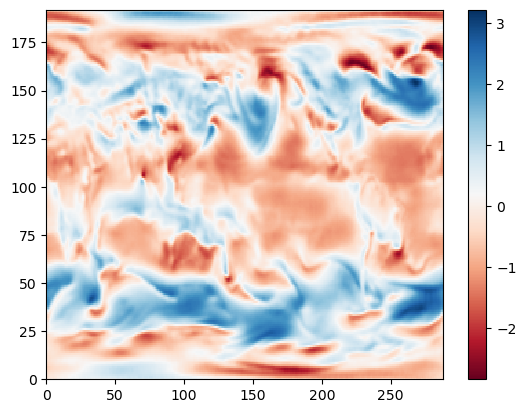

In [16]:
plt.pcolor(x[0,30,0,:,:].cpu(), cmap='RdBu')
plt.colorbar()
plt.show()

In [31]:
DSdo['U']

<xarray.DataArray 'U' (time: 1, level: 32, latitude: 192, longitude: 288)> Size: 7MB
[1769472 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 8B 1980-09-10T06:00:00
  * level      (level) int64 256B 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * latitude   (latitude) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * longitude  (longitude) float32 1kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Attributes:
    long_name:      U component of wind
    standard_name:  eastward_wind
    short_name:     u
    units:          m s**-1

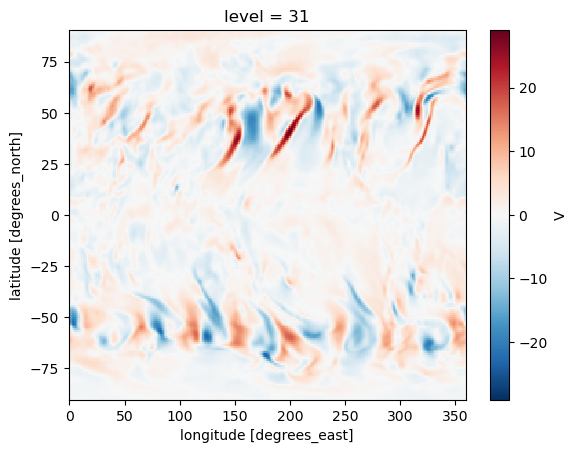

In [51]:
FNS  = sorted(glob('/glade/derecho/scratch/wchapman/CREDIT/wxformer_1deg_SpatPS/No_Post/1980-01-01T00Z/pred_1980-01-01T00Z_*.nc'))
var = 'V'

DSdo = xr.open_dataset(FNS[200])[var].squeeze() - xr.open_dataset(FNS[202])[var].squeeze()
try:
    DSdo.sel(level=31).squeeze().plot()
    plt.show()
except:
    DSdo.squeeze().plot()
    plt.show()

In [60]:
DS = xr.open_mfdataset(FNS[1:31])
DSm  = DS['PS'].mean('time')

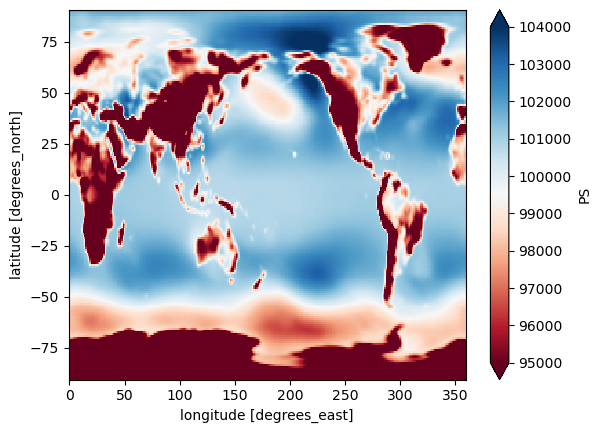

In [76]:
DSm.plot(cmap='RdBu',vmin=95000,vmax=104000)

In [81]:
FNS  = sorted(glob('/glade/derecho/scratch/wchapman/CREDIT/wxformer_1deg_SpatPS/No_Post/1980-01-01T00Z/1D/averaged_PSTUVQtot_*.nc'))
DS = xr.open_mfdataset(FNS)

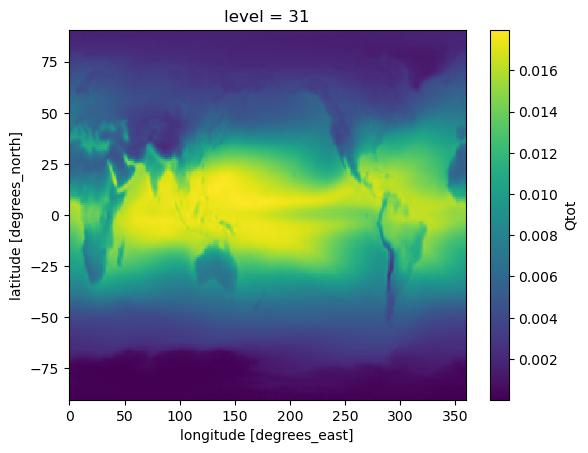

In [96]:
DS['Qtot'].mean('time').sel(level=31).plot()